## Temperature forecasting for different cities in the world

## Introduction
For this project you are asked to analyze three datasets, called respectively:
1. pollution_us_2000_2016.csv
2. greenhouse_gas_inventory_data_data.csv
3. GlobalLandTemperaturesByCity.csv

You are asked to extract from dataset 2 only the US countries (for which we have info in the other datasets) and to perform the following tasks:
- to measure how pollution and temperature create cluster tracing the high populated cities in the world
- to analyze the correlation between pollution data and temperature change.
- to predict the yearly temperature change of a given city over a given time period, using the <b>ARIMA model</b> for <b>time series forecasting</b>, that is a model for time series forecasting integrating AR models with Moving Average.
- (OPTIONAL) rank the 5 cities that will have a highest temperature change in US


### TASK1 :Cluster Analysis
You use K-means or DBSCAN to perform the cluster analysis, and create a new dataset where the cities are associated to the different identified clusters

### TASK 2: Correlation Analysis

You measure the correlation between:
- temperature and latitude
- temperature and pollution
- temperature change (difference between the average temperature measured over the last 3 years and the previous temperature) and pollution


### TASK 3: Predicting the Temperature of a Given City across a Specified Time Period
After reading the data in the temperature data set, for each city cluster, before applying the ARIMA model you perform the following steps:

- EDA
- data cleaning and preprocessing (Converting the 'dt' (date) column to DateTime format, removing NaN)
- feature selection
- make the time-series stationary
- check for stationarity : Calculating the Augmented Dickey-Fuller Test statistic 
- identify the (p, q) order of the ARIMA model using ACF partial autocorrelation plot

Then:

-fit the ARIMA model using the calculated p, q values.
-calculate the MSE with respect to the true temp. measurements to estimate the performance of the model


NOTE: ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we can use
- seasonal decomposition
- differencing

In [72]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets


import seaborn as sns


In [ ]:
# bellou

## My tasks 
1. Rename things 

## SECTION 1: Cluster Analysis

---
Loading the data in CSV format as Pandas DataFrame 
---
1. Clean the data by dropping Nan Values
2. Setting the date as index of the three dataframes
3. Selecting the relevant features we will consider 

In [91]:
# read the csv file containing the polluters 
df_pollution = pd.read_csv("./Project_3/data/data-project3/pollution_us_2000_2016.csv")
# read the csv file containing temperature data into a DataFrame
df_temp = pd.read_csv("./Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv")
# reading the 
df_greenhouse = pd.read_csv("./Project_3/data/data-project3/greenhouse_gas_inventory_data_data(1).csv")

In [90]:
mask = df_greenhouse["country_or_area"] == "United States of America"
df_greenhosue[mask]

0       False
1       False
2       False
3       False
4       False
        ...  
8401     True
8402     True
8403     True
8404     True
8405     True
Name: country_or_area, Length: 8406, dtype: bool

In [74]:
# Droping the NaN values 
df_pollution.dropna(inplace=True)

df_temp.dropna(inplace=True)

df_greenhouse.dropna(inplace=True)

In [75]:
# Dropping duplicates 
df_pollution.drop_duplicates(subset=None, keep='first', inplace=True)
df_temp.drop_duplicates(subset=None, keep='first', inplace=True)
df_greenhouse.drop_duplicates(subset=None, keep='first', inplace=True)

In [76]:
# Setting the date as an index of the three dataframes 
df_pollution.set_index("Date Local", inplace=True)
df_temp.set_index("dt", inplace=True)
df_greenhouse.set_index("year", inplace=True)

In [77]:
# Changing the type of the index to dattime 
df_pollution.index = pd.to_datetime(df_pollution.index)
df_temp.index = pd.to_datetime(df_temp.index)
df_greenhouse.index = pd.to_datetime(df_greenhouse.index)

In [78]:
cutoff_date = pd.to_datetime("2000-01-01")
df_pollution = df_pollution[df_pollution.index >= cutoff_date]
df_temp = df_temp[df_temp.index >= cutoff_date]
df_greenhouse = df_greenhouse[df_greenhouse.index >= cutoff_date]

In [79]:
mask = df_temp["Country"] == "United States"
df_temp = df_temp[mask]

In [80]:
# Dropping two uncessary columns 
df_temp = df_temp.drop(["Country", "AverageTemperatureUncertainty"], axis=1)

In [81]:
df_pollution = df_pollution[["City","NO2 Mean", "O3 Mean", "SO2 Mean", "CO Mean"]]
# df_temp = df_temp[["AverageTemperature", "City", "Latitude", "Longitude"]]
df_greenhouse = df_greenhouse[["country_or_area", "value"]]

In [82]:
mask = df_greenhouse["country_or_area"] == "United States of America"
df_greenhouse = df_greenhouse[mask]

In [83]:
df_pollution.index = df_pollution.index.year
df_greenhosue.index = df_greenhosue.index.year
df_temp.index = df_temp.index.year

AttributeError: 'Index' object has no attribute 'year'

country_or_area    United States of America
value                            293.205663
Name: 1970, dtype: object

In [124]:
cutoff_date = pd.to_datetime("2000-01-01")
cutoff_date

Timestamp('2000-01-01 00:00:00')

In [125]:
df_pollution = df_pollution[df_pollution.index >= cutoff_date]
df_temp = df_temp[df_temp.index >= cutoff_date]
# df_greenhouse = df_greenhouse[df_greenhouse.index >= cutoff_date]

In [127]:
df_temp

,AverageTemperature,City,Latitude,Longitude
dt,,,,
2000-01-01,8.039,Abilene,32.95N,100.53W
2000-02-01,11.908,Abilene,32.95N,100.53W
2000-03-01,14.423,Abilene,32.95N,100.53W
2000-04-01,18.274,Abilene,32.95N,100.53W
2000-05-01,25.358,Abilene,32.95N,100.53W
...,...,...,...,...
2013-05-01,15.544,Yonkers,40.99N,74.56W
2013-06-01,20.892,Yonkers,40.99N,74.56W
2013-07-01,24.722,Yonkers,40.99N,74.56W


## SECTION 2: Correlation Analysis

In [106]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split # SPlit the data for training

from sklearn.preprocessing import MinMaxScaler # Scale the data 
import seaborn as sns

In [107]:
# Reading the temperture data 
df = pd.read_csv("./Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv")

In [108]:
print(f"The data have the following shape {df.shape}")

The data have the following shape (8599212, 7)


In [109]:
# Cleaning the data from duplicates and undefined enteries 
# Droping NaN
df = df.dropna()
# Removing duplicates 
df = df.drop_duplicates(subset=None, keep='first')
# Setting the data as index 
df.set_index("dt", inplace=True)

In [110]:
print(f"The cleaned data has the following shape {df.shape}")

The cleaned data has the following shape (8235082, 6)


In [111]:
# Setting the data type of the index to be date time 
df.index = pd.to_datetime(df.index)

In [112]:
# Extracting only the US 
mask = df["Country"] == "United States" # Creating a mask that seclects the US from the data 
df = df[mask] # applying the mask to the dataframe 
df

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W
...,...,...,...,...,...,...
2013-05-01,15.544,0.281,Yonkers,United States,40.99N,74.56W
2013-06-01,20.892,0.273,Yonkers,United States,40.99N,74.56W
2013-07-01,24.722,0.279,Yonkers,United States,40.99N,74.56W


In [113]:
# Dropping uncessary columns 
df = df.drop(["AverageTemperatureUncertainty", "Country", "Longitude", "Latitude"], axis=1)

In [114]:
# Scaling the average temperature value 
temp_vals = df["AverageTemperature"].values.reshape(-1, 1)

In [115]:
# Scaling the temperature 
scaler = MinMaxScaler()
scaled_temp = scaler.fit_transform(temp_vals)

In [116]:
# # Assigning the scaled temperature to the corresponding dataframe column  
df["AverageTemperature"] = scaled_temp

In [117]:
# Saving the names of the cities as an array that will be used later for the resembled data 
city_names = df["City"].unique()

In [118]:
print(f"There are {len(city_names)} cities in this dataset")

There are 248 cities in this dataset


In [119]:
# df.index = df.index.year 
df.shape 

(661524, 2)

In [178]:
# df = df.drop("City", axis=1)

In [120]:
df = df.groupby(["City"]).resample("YE").mean()

In [121]:
df = df.dropna()

In [122]:
# Seclecting 4 random cities from the dataset 
np.random.seed(42)
rd_cities = np.random.choice(city_names, 16, replace=False)
rd_cities

array(['Charleston', 'Anaheim', 'Riverside', 'Greensboro', 'Orange',
       'Worcester', 'San Diego', 'Jersey City', 'Antioch', 'Warren',
       'Virginia Beach', 'Washington', 'West Covina', 'Reno',
       'Evansville', 'Overland Park'], dtype=object)

## Visulizing the change in average temperature for 16 US cities asa fucntion of time 

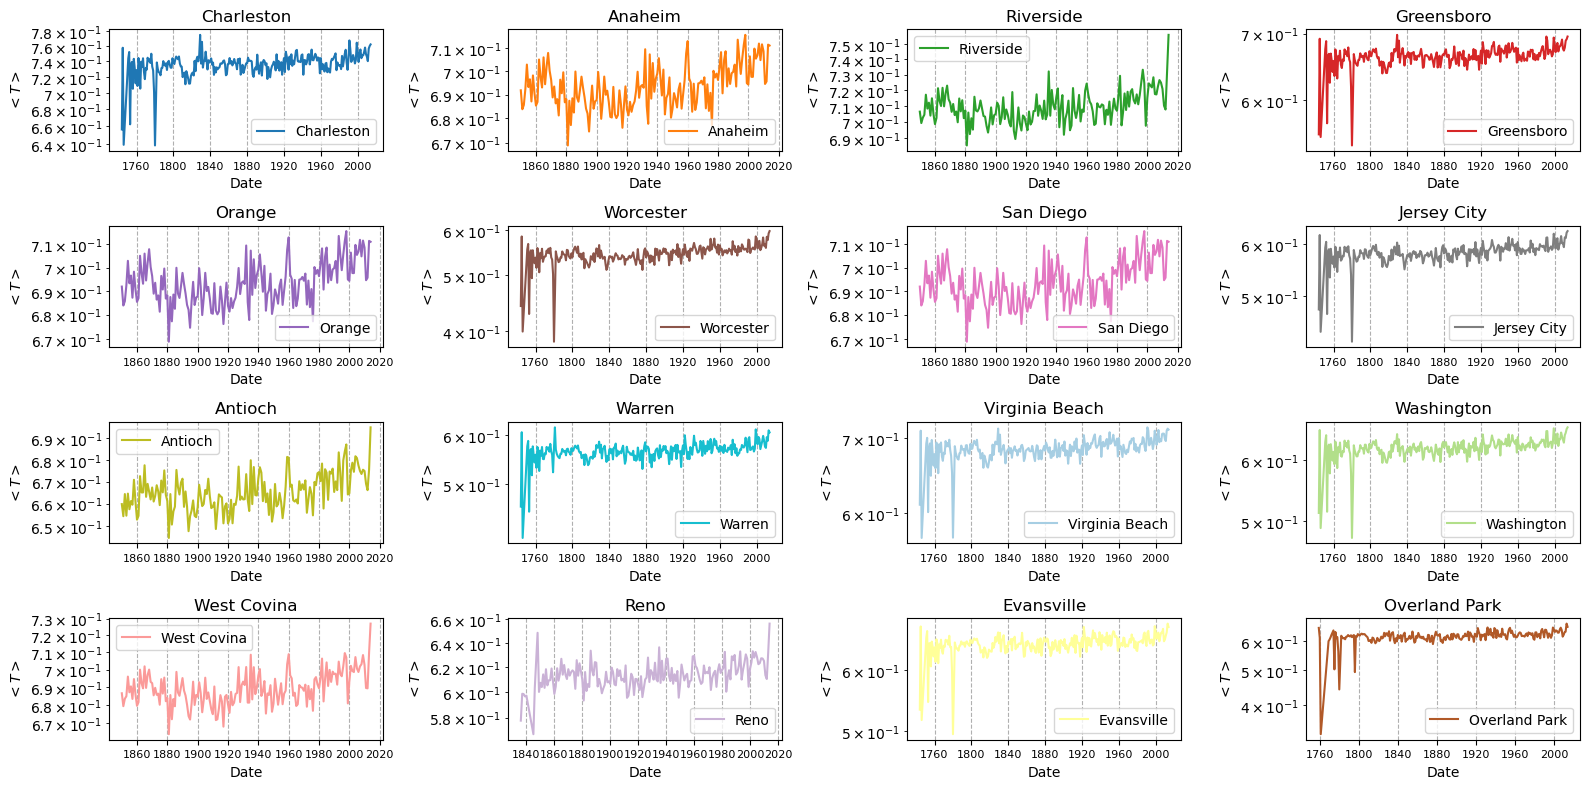

In [123]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
for i, name in enumerate(rd_cities):
    data = df.loc[name]
    ax[i].plot(data.index, data["AverageTemperature"], color=colors[i], label=f"{name}") # Plot on the i-th subplot
    ax[i].set_title(name) # Add title for each city
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(r"$<T>$")
    ax[i].legend(loc="best")
    ax[i].tick_params(axis='x', labelsize=8)
    ax[i].set_yscale("log")
    # ax[i].set_yticks(np.linspace(0, 1, 5))
    ax[i].grid(axis="both", ls="--")
plt.tight_layout()
plt.show()

# Splitting the data into training and testing 

In [124]:
# Creating a dictionary with the city names as keys and the corresponding dataframe as a value of the dictionary 
data = {}
for name in city_names:
    data[f"{name}"] = df.loc[name]

In [125]:
# Splitting the data into training and testing 
train_data = {} # Dictionary for the training data per city 
test_data = {} # Dictionary for the testing data per city 

for key, value in data.items():
    # Getting the feature of the data 
    temp_var = data[key] 
    X = temp_var.index 

    # Getting the target of the data
    y = temp_var["AverageTemperature"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
    # Assigning the feature and target to the training data 
    train_df = pd.DataFrame({"AverageTemperature": y_train}, index=X_train)
    train_data[key] = train_df

    # Assigning the feature and target to the testing data
    test_df = pd.DataFrame({"AverageTemperature": y_test}, index=X_test)
    test_data[key] = test_df

In [100]:
print(f"The size of the testing data points is: {len(test_df)}")
print(f"The size of the training data points is: {len(train_df)}")

The size of the testing data points is: 80
The size of the training data points is: 186


# Making the time series stationary 

In [135]:
# additive_decomposition = STL(endog=df.loc["Abilene"], robust=True, period=12).fit()

# Iterate over the training dataset 
# Decompose the target values
# Save the dates as pandas datetime 
train_data_stationary = {} # Dictionary to save the stationary time series 
# List to save the stationariyt test results in 
adf_result = []
for key, value in train_data.items():
    # Get the dates 
    temp_var = train_data[key] # Use a temporary variable to save the subdataframe 
    # Dates that will be used as an index for the subdataframes 
    X = temp_var.index
    # Get the target values of the time series 
    y = temp_var["AverageTemperature"]
    # Reshape the target 
    y = y.to_numpy().reshape(-1, 1)

    # Apply seasonal decomposition 
    seasonal_decomposition = STL(endog=y, robust=True, period=12).fit() 
    trend = seasonal_decomposition.trend.reshape(-1, 1)
    seasonal = seasonal_decomposition.seasonal.reshape(-1, 1)
    # Remove the seasonal and trends
    y = y - trend - seasonal
    y = y.flatten()
    temp_result = adfuller(y)
    adf_result.append(temp_result)
    temp_df = pd.DataFrame({"AverageTemperature": y}, index=X)    

    # Add the city to the dictionary 

    train_data_stationary[key] = temp_df

2.5789909087012272e-05

## Visulizing Stationary Time Series 

/tmp/ipykernel_24444/4209880043.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend(loc="best", title=f"p-value: {adf_result[i][1]:.2e}")


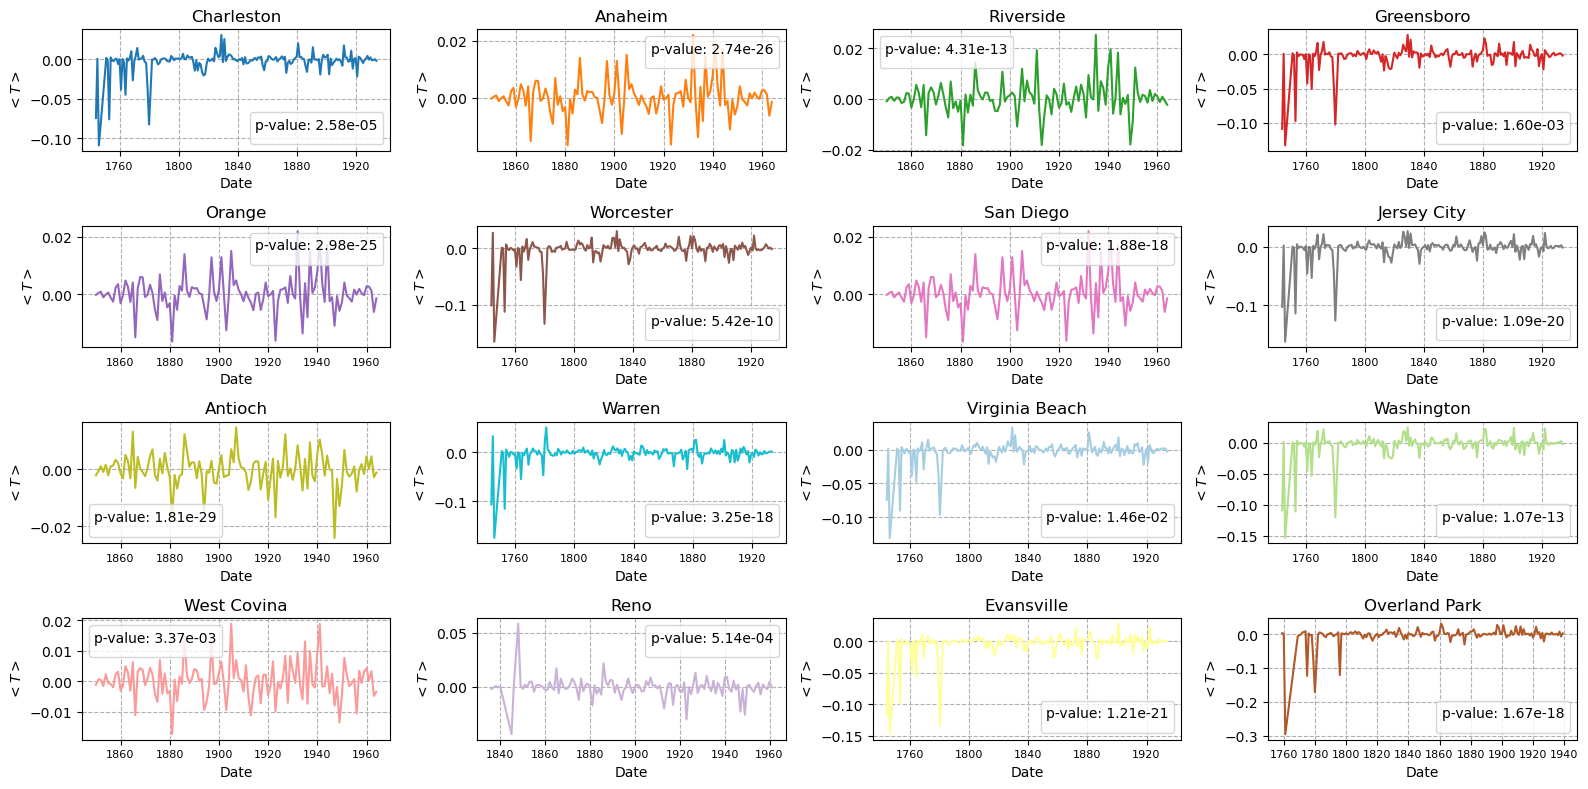

In [146]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
for i, name in enumerate(rd_cities):
    data = train_data_stationary[name]
    ax[i].plot(data.index, data["AverageTemperature"], color=colors[i]) # Plot on the i-th subplot
    ax[i].set_title(name) # Add title for each city
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(r"$<T>$")
    ax[i].legend(loc="best", title=f"p-value: {adf_result[i][1]:.2e}")
    ax[i].tick_params(axis='x', labelsize=8)
    ax[i].grid(axis="both", ls="--")
plt.tight_layout()
plt.show()

We can reject the null-hypothesis of the non-stationarity of the data since the p-values of the test are less than $ 0.05 $

In [82]:
x = df.loc["Abilene"].to_numpy()

In [94]:
# In order to remove the seasonal part and the trend the target array should be converted to numpy and reshaped 
x = x.reshape(-1, 1)
z = additive_decomposition.trend.to_numpy().reshape(-1, 1) 
k = additive_decomposition.seasonal.to_numpy().reshape(-1, 1)
print()

In [90]:
test  = x - z - k 

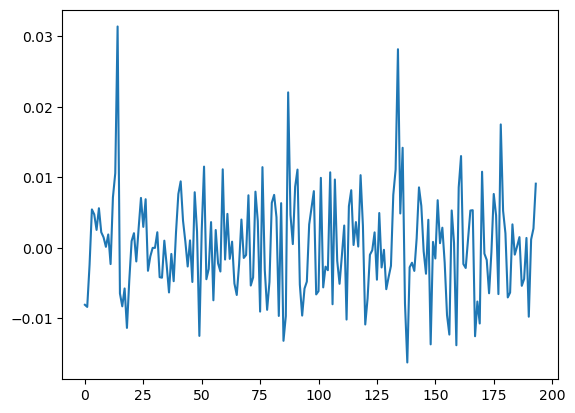

In [93]:
plt.plot(test)
# plt.yscale("log")

##SECTION 3: ARIMA model for temperature forecasting

In [101]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
#(OPTIONAL) To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,#))  # taking values from 0 to # (decide this looking at PACF)

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

SyntaxError: '(' was never closed (61021133.py, line 4)

In [ ]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)



## Conclusion

write here the report for the project